In [2]:
# GRU Algorithm based on tutorial: https://www.youtube.com/watch?v=6f67zrH-_IE (by Hvass Laboratories)
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

# Applying this Deep Learning Algorithm in the smart parking dataset for timeseries forecasting

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,10
from sklearn.preprocessing import MinMaxScaler

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

C:\Users\lrmen\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lrmen\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lrmen\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lrmen\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [5]:
inputCSV = '../datasets/prepared/parking-prepared.csv';
data = pd.read_csv(inputCSV)

data['spots_available'] = pd.to_numeric(data['spots_available'])
data['verification_datetime'] = pd.to_datetime(data['verification_datetime'])
data = data.set_index('verification_datetime').asfreq('15min')

data.index = pd.DatetimeIndex(data.index, freq=data.index.inferred_freq)

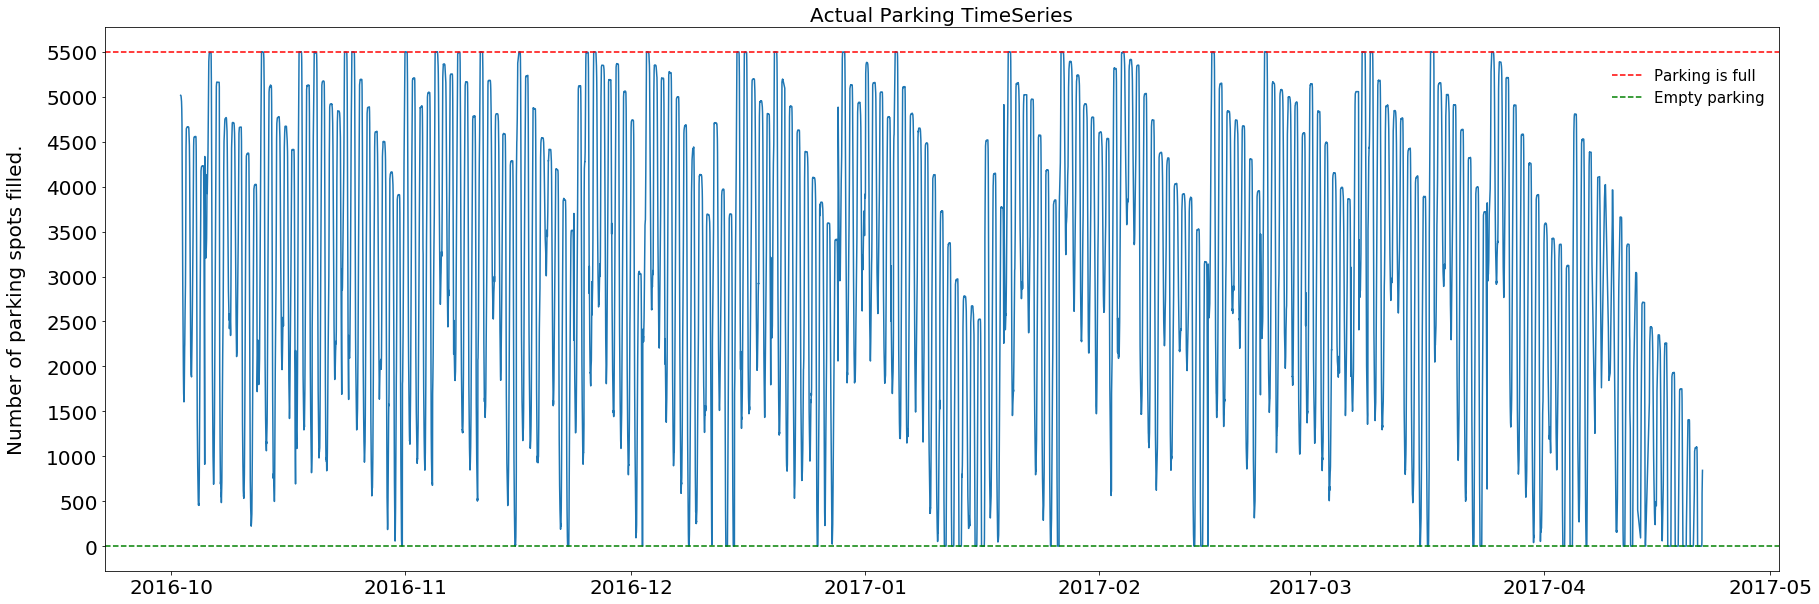

In [6]:
# Filter the dataset from the range of time with the minimun noise
prepared_data = data.copy()

prepared_data = prepared_data.dropna()

#prepared_data = prepared_data[(prepared_data.index.to_series().dt.day >= 3) | (prepared_data.index.to_series().dt.month != 6)]

plt.tick_params(axis='both', which='major',  labelsize=20)
plt.ylabel('Number of parking spots filled.', labelpad=20,  fontsize=20)

#plt.plot(y=5500, color='r', linestyle='dashed')
plt.title("Actual Parking TimeSeries", fontsize=20)
plt.plot(prepared_data)

plt.locator_params(axis='y', nbins=21)
plt.axhline(y=5500, color='r', linestyle='--', label="Parking is full")
plt.axhline(y=0, color='g', linestyle='--', label="Empty parking")
plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1, 0.95), prop={'size': 15})

In [7]:
inputCSV = '../datasets/prepared/parking-prepared.csv';
data = pd.read_csv(inputCSV)

data['spots_available'] = pd.to_numeric(data['spots_available'])
data['verification_datetime'] = pd.to_datetime(data['verification_datetime'])
data = data.set_index('verification_datetime').asfreq('15min')

data.index = pd.DatetimeIndex(data.index, freq=data.index.inferred_freq)

# Fill All Empty Values with the last 15 min valid value or the medium of the last valid before + the last after value
for i in range(0, len(data)):
    if np.isnan(data.iloc[i]['spots_available']):
        if np.isnan(data.iloc[i+1]['spots_available']):
            data.iloc[i]['spots_available'] = data.iloc[i-1]['spots_available']
        else:
            data.iloc[i]['spots_available'] = (data.iloc[i-1]['spots_available'] + data.iloc[i+1]['spots_available']) / 2

data = data[74:]
print("Total Days: ",len(data)/96)
print(data.head(5)) # First Day Starting at 00:00 with 96 periods
print(data.tail(5)) # Last Day Ending at 23:45 with 96 periods

Total Days:  201.0
                       spots_available
verification_datetime                 
2016-10-03 00:00:00             4651.0
2016-10-03 00:15:00             4652.0
2016-10-03 00:30:00             4652.5
2016-10-03 00:45:00             4653.0
2016-10-03 01:00:00             4656.0
                       spots_available
verification_datetime                 
2017-04-21 22:45:00              663.0
2017-04-21 23:00:00              739.0
2017-04-21 23:15:00              773.0
2017-04-21 23:30:00              807.0
2017-04-21 23:45:00              843.0


Total Days:  191.0


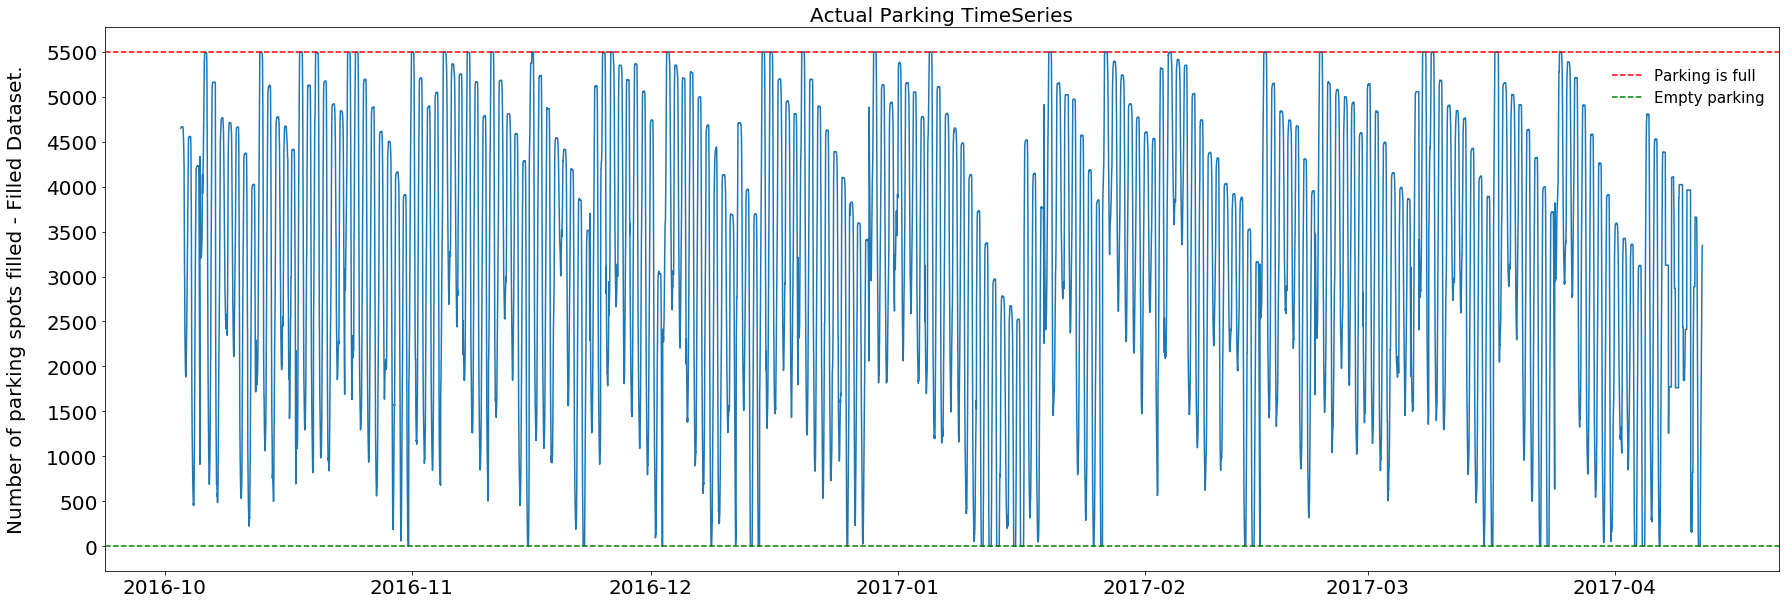

In [8]:
# Filter the dataset from the range of time with the minimun noise
prepared_data = data.copy()
prepared_data = prepared_data[0:-960]

print("Total Days: ",len(prepared_data)/96)

#prepared_data = prepared_data[(prepared_data.index.to_series().dt.day >= 3) | (prepared_data.index.to_series().dt.month != 6)]

plt.tick_params(axis='both', which='major',  labelsize=20)
plt.ylabel('Number of parking spots filled - Filled Dataset.', labelpad=20,  fontsize=20)

#plt.plot(y=5500, color='r', linestyle='dashed')
plt.title("Actual Parking TimeSeries", fontsize=20)
plt.plot(prepared_data)

plt.locator_params(axis='y', nbins=21)
plt.axhline(y=5500, color='r', linestyle='--', label="Parking is full")
plt.axhline(y=0, color='g', linestyle='--', label="Empty parking")
plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1, 0.95), prop={'size': 15})

In [9]:
shift_days = 7
shift_steps = shift_days * 96 # 15 min periods -> 96 for each day

df_targets = prepared_data.shift(-shift_steps)
df_targets.tail(5)

,spots_available
verification_datetime,
2017-04-11 22:45:00,NaN
2017-04-11 23:00:00,NaN
2017-04-11 23:15:00,NaN
2017-04-11 23:30:00,NaN
2017-04-11 23:45:00,NaN


In [10]:
# The Last 5 Head values of prepared date has the same values of the First 5 Head values of df_targets
# But the time are different, this difference are the number of predict days above

print(prepared_data.head(shift_steps + 5))
print(df_targets.head(5))

                       spots_available
verification_datetime                 
2016-10-03 00:00:00             4651.0
2016-10-03 00:15:00             4652.0
2016-10-03 00:30:00             4652.5
2016-10-03 00:45:00             4653.0
2016-10-03 01:00:00             4656.0
...                                ...
2016-10-10 00:00:00             4643.0
2016-10-10 00:15:00             4659.0
2016-10-10 00:30:00             4659.5
2016-10-10 00:45:00             4660.0
2016-10-10 01:00:00             4660.0

[677 rows x 1 columns]
                       spots_available
verification_datetime                 
2016-10-03 00:00:00             4643.0
2016-10-03 00:15:00             4659.0
2016-10-03 00:30:00             4659.5
2016-10-03 00:45:00             4660.0
2016-10-03 01:00:00             4660.0


In [11]:
x_data = prepared_data.values[0:-shift_steps]
print(type(x_data))
print("Shape: ",x_data.shape)

<class 'numpy.ndarray'>
Shape:  (17664, 1)


In [12]:
y_data = df_targets.values[0:-shift_steps]
print(type(y_data))
print("Shape: ",y_data.shape)

<class 'numpy.ndarray'>
Shape:  (17664, 1)


In [13]:
train_split = 0.9
num_train = int(train_split * len(x_data))
num_train

15897

In [14]:
num_test = len(x_data) - num_train
num_test

1767

In [15]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

17664

In [16]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

17664

In [17]:
num_x_signals = x_data.shape[1]
num_x_signals

1

In [18]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [19]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 5500.0


In [20]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))
x_test_scaled = x_scaler.transform(x_test)

Min: 0.0
Max: 0.9999999999999999


In [21]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [22]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(15897, 1)
(15897, 1)


In [44]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [45]:
batch_size = 256

sequence_length = shift_steps * 8 # 8 Weeks for Random
sequence_length

5376

In [46]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

generator

<generator object batch_generator at 0x000001F44F6DC4C8>

In [47]:
x_batch, y_batch = next(generator)

In [48]:
print(x_batch.shape)
print(y_batch.shape)

(256, 5376, 1)
(256, 5376, 1)


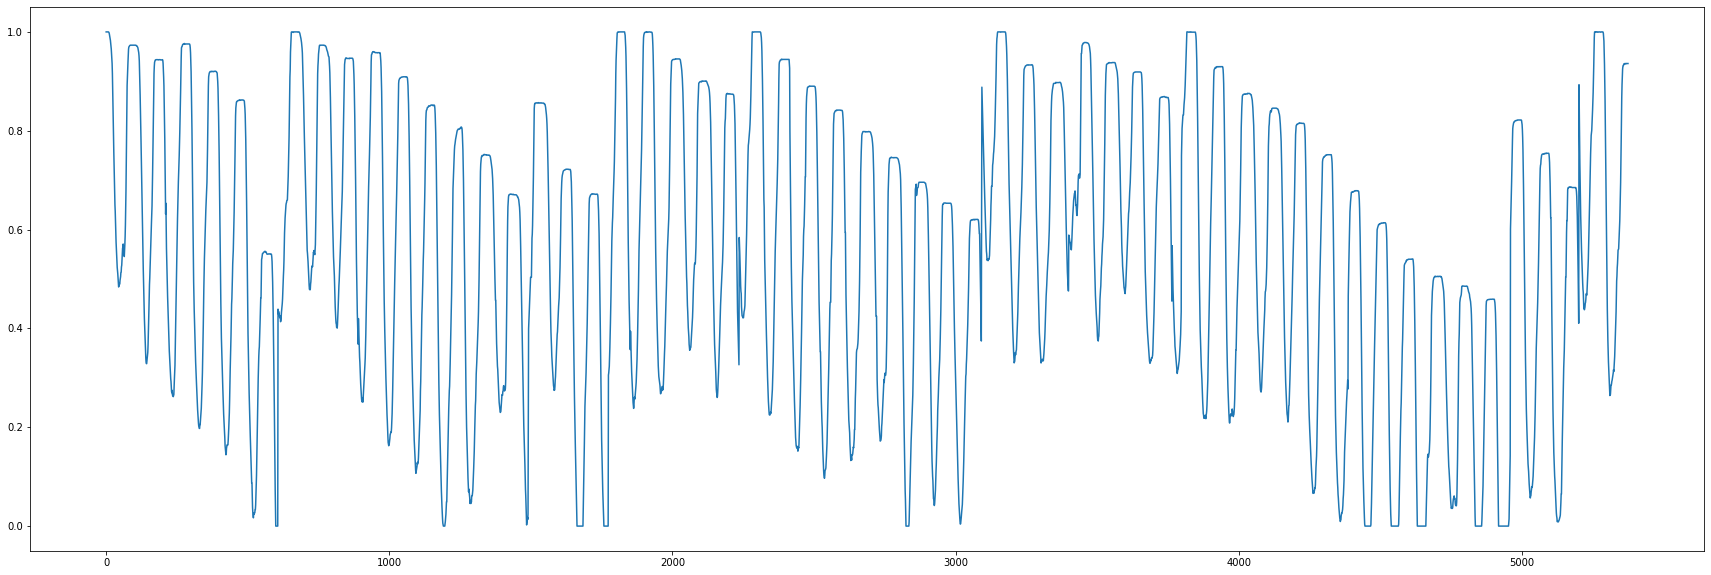

In [49]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

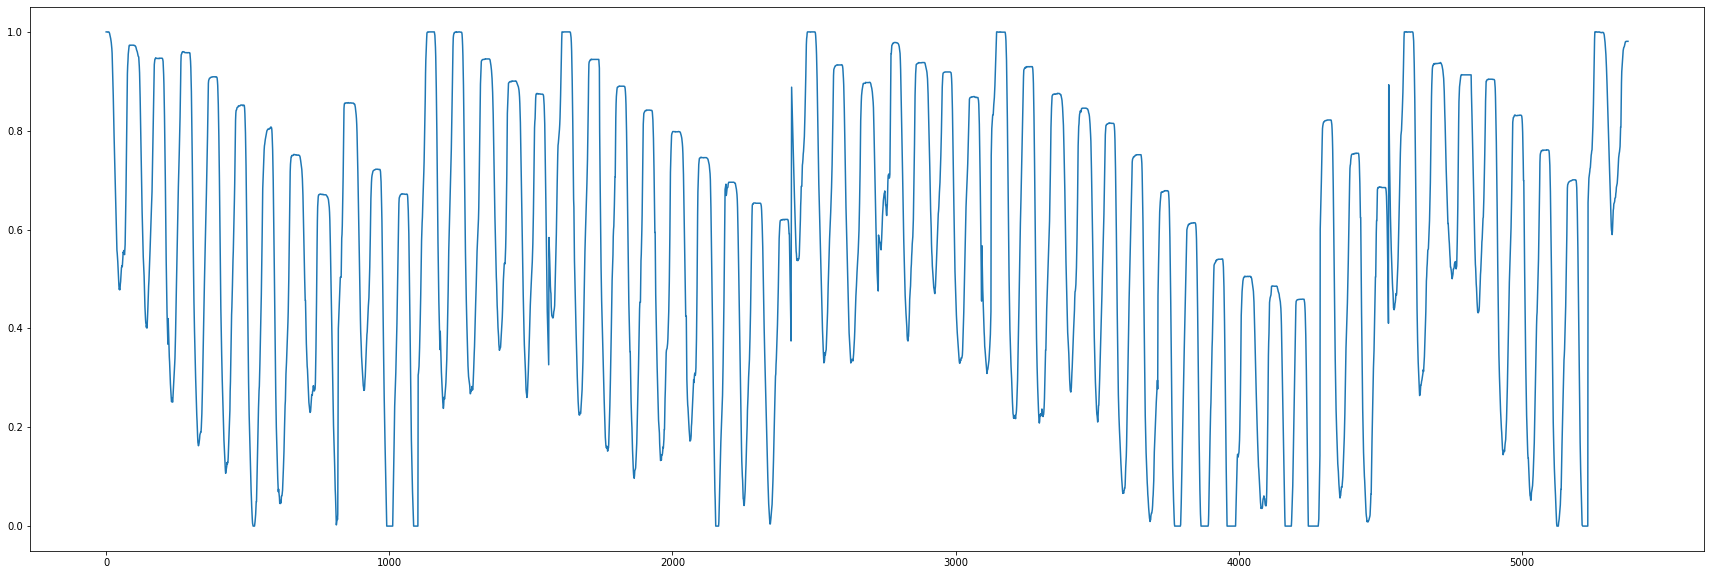

In [50]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

# Validation

In [30]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Creating Neural Network

In [31]:
model = Sequential()

model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

model.add(Dense(num_y_signals, activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [32]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [33]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

## Loss Func

In [34]:
warmup_steps = 50

In [35]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [36]:
optimizer = RMSprop(lr=1e-3)

In [37]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         789504    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           2         
Total params: 790,019
Trainable params: 790,019
Non-trainable params: 0
_________________________________________________________________


## CallBack

In [38]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [39]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [40]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [41]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [42]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [43]:
%%time
model.fit(x=generator,
          epochs=1,
          
          shuffle=False
          #steps_per_epoch=2,
          #validation_data=validation_data,
          #callbacks=callbacks
         )

ValueError: Please specify the number of steps via the `steps_per_epoch` argument.